In [128]:
using LinearAlgebra

## Implement B-Splines

Cf. <a href="https://personal.math.vt.edu/embree/math5466/lecture10.pdf"> https://personal.math.vt.edu/embree/math5466/lecture10.pdf </a>

TODO for Sriram and Noah: Read this paper https://link.springer.com/chapter/10.1007/978-3-319-06569-4_25
And lookup references on interval analysis for B-splines.

De Boor, C. (1978). A Practical Guide to Splines. Springer-Verlag.
Piegl, L., & Tiller, W. (1997). The NURBS Book. Springer-Verlag.


In [129]:
struct BSpline2
    grid_knots::Vector{Float64} # size must be n + 2 * k + 1
    ctrl_points::Vector{Float64} # size must be n + k 
end

##Flux.@layer BSpline2 trainable=(ctrl_points,)

In [130]:
function BSpline2(lb::Float64, ub::Float64; n::Int = 20)
    k = 2
    # control points -- initialize randomly
    cpoints::Vector{Float64} = randn(Float64, n+k)
    grid_pts::Vector{Float64} = LinRange(lb, ub, n+1) # create uniformly
    # add 2 points before the lower bound and 2 points after the upper bound
    pushfirst!(grid_pts, lb-0.5)
    pushfirst!(grid_pts, lb-1.0)
    push!(grid_pts, ub + 0.5)
    push!(grid_pts, ub + 1.0)
    # return BSpline object
    BSpline2( grid_pts, cpoints)
end

BSpline2

In [131]:
bs = BSpline2(-10.0, 10.0)

BSpline2([-11.0, -10.5, -10.0, -9.0, -8.0, -7.0, -6.0, -5.0, -4.0, -3.0  …  3.0, 3.9999999999999996, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 10.5, 11.0], [-0.9179129194082037, 0.7897779270518365, 0.9222184651777672, -0.1661140374533239, -0.257568832514993, -0.039054420434274074, 0.8868681960258398, -0.23649515370432175, 0.45940916136536375, 0.5171724999399555  …  -0.4334024970174989, -0.8936624515357613, 0.09794083715605956, -0.8942126969310744, 0.3553381897865074, 2.5431394827474425, 1.2260201247679392, 0.12812013074110018, 1.2865452306277327, -1.152706961532666])

![image.png](degree3.jpg)

In [132]:
function basis2(bs::BSpline2, x::Float64)
   n = size(bs.grid_knots)[1] - 1
   # these are the zeroth basis function
   b0::Vector{Float64} = (x .>= bs.grid_knots[1:end-1]) .& (x .< bs.grid_knots[2:end]) # piecewise constant
   # calculate the first basis functions
   b1_numerator_left = x .-  bs.grid_knots[1:end-2]
   b1_denominator_left = bs.grid_knots[2:end-1] .- bs.grid_knots[1:end-2]
   b1_numerator_right = bs.grid_knots[3:end] .- x  
   b1_denominator_right = bs.grid_knots[3:end]  .- bs.grid_knots[2:end-1]
    # piecewise linear functions
   b1::Vector{Float64} = (b1_numerator_left ./ b1_denominator_left) .* b0[1:end-1] + (b1_numerator_right ./ b1_denominator_right) .* b0[2:end]
   # calculate the second basis functions
   b2_numerator_left = x .- bs.grid_knots[1:end-3]
   b2_numerator_right = bs.grid_knots[4:end] .- x  
   b2_denominator_left = bs.grid_knots[3:end-1] .- bs.grid_knots[1:end-3] 
   b2_denominator_right = bs.grid_knots[4:end] .- bs.grid_knots[2:end-2]
    #piecewise quadratic functions.
   b2::Vector{Float64} = (b2_numerator_left ./ b2_denominator_left) .* b1[1:end-1] + (b2_numerator_right ./ b2_denominator_right) .* b1[2:end]
   return b2
end

basis2 (generic function with 1 method)

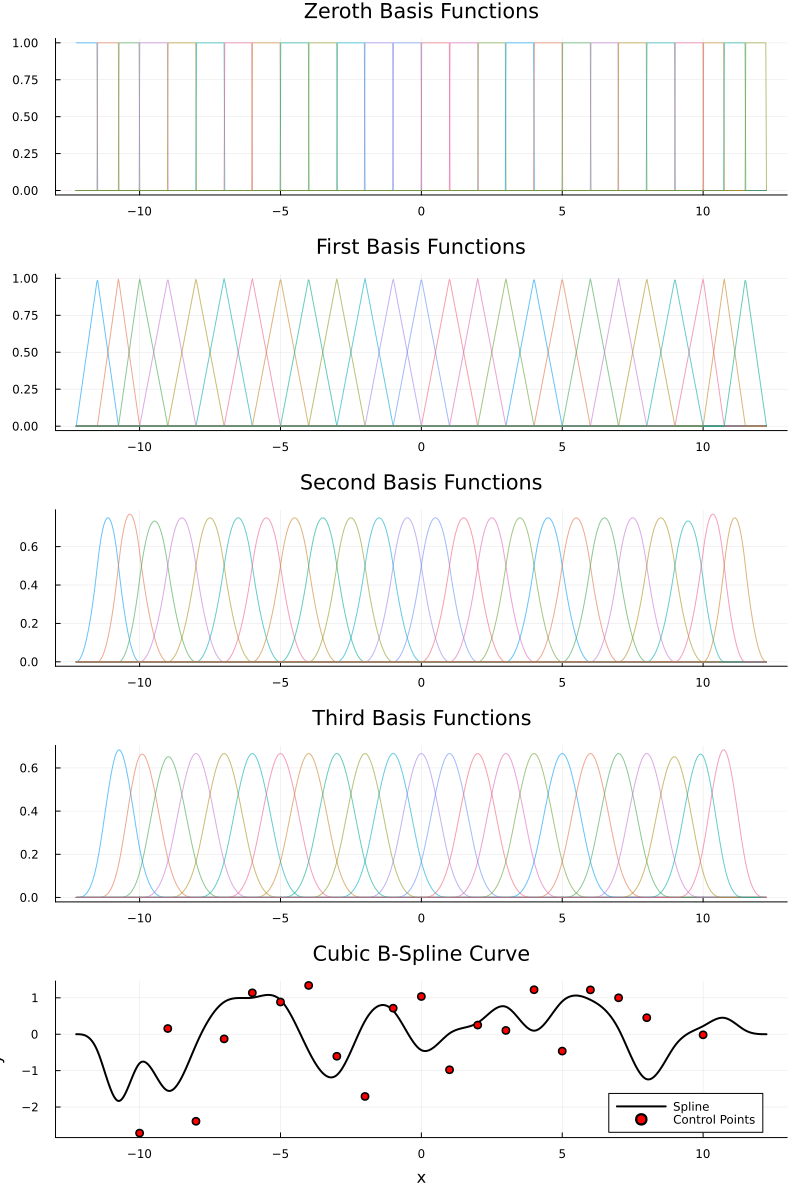

In [133]:
using Plots

struct BSpline3
    grid_knots::Vector{Float64}  # size must be n + 2 * k + 1, where k = 3 for cubic
    ctrl_points::Vector{Float64}  # size must be n + k
end

function BSpline3(lb::Float64, ub::Float64; n::Int = 20)
    k = 3  # degree 3 for cubic spline
    # control points -- initialize randomly
    cpoints::Vector{Float64} = randn(Float64, n+k)
    grid_pts::Vector{Float64} = LinRange(lb, ub, n+1)
    # add 3 points before lower bound and 3 points after upper bound (k=3)
    pushfirst!(grid_pts, lb-0.75)
    pushfirst!(grid_pts, lb-1.5)
    pushfirst!(grid_pts, lb-2.25)
    push!(grid_pts, ub+0.75)
    push!(grid_pts, ub+1.5)
    push!(grid_pts, ub+2.25)
    BSpline3(grid_pts, cpoints)
end

function basis3(bs::BSpline3, x::Float64)
    n = size(bs.grid_knots)[1] - 1
    
    # zeroth basis function (piecewise constant)
    b0::Vector{Float64} = (x .>= bs.grid_knots[1:end-1]) .& (x .< bs.grid_knots[2:end])
    
    # first basis functions (piecewise linear)
    b1_numerator_left = x .- bs.grid_knots[1:end-2]
    b1_denominator_left = bs.grid_knots[2:end-1] .- bs.grid_knots[1:end-2]
    b1_numerator_right = bs.grid_knots[3:end] .- x  
    b1_denominator_right = bs.grid_knots[3:end] .- bs.grid_knots[2:end-1]
    
    b1::Vector{Float64} = (b1_numerator_left ./ b1_denominator_left) .* b0[1:end-1] + 
                         (b1_numerator_right ./ b1_denominator_right) .* b0[2:end]
    
    # second basis functions (piecewise quadratic)
    b2_numerator_left = x .- bs.grid_knots[1:end-3]
    b2_numerator_right = bs.grid_knots[4:end] .- x  
    b2_denominator_left = bs.grid_knots[3:end-1] .- bs.grid_knots[1:end-3] 
    b2_denominator_right = bs.grid_knots[4:end] .- bs.grid_knots[2:end-2]
    
    b2::Vector{Float64} = (b2_numerator_left ./ b2_denominator_left) .* b1[1:end-1] + 
                         (b2_numerator_right ./ b2_denominator_right) .* b1[2:end]
    
    # third basis functions (piecewise cubic)
    b3_numerator_left = x .- bs.grid_knots[1:end-4]
    b3_numerator_right = bs.grid_knots[5:end] .- x
    b3_denominator_left = bs.grid_knots[4:end-1] .- bs.grid_knots[1:end-4]
    b3_denominator_right = bs.grid_knots[5:end] .- bs.grid_knots[2:end-3]
    
    b3::Vector{Float64} = (b3_numerator_left ./ b3_denominator_left) .* b2[1:end-1] + 
                         (b3_numerator_right ./ b3_denominator_right) .* b2[2:end]
    
    return b0, b1, b2, b3
end

function eval_cubic_spline(bs::BSpline3, x)
    _, _, _, b3 = basis3(bs, x)
    b3 ⋅ bs.ctrl_points
end

function plot_cubic_bspline_with_basis()
    # Create a B-spline of degree 3
    bs = BSpline3(-10.0, 10.0)  # fewer control points for clarity
    
    # Create range of x values for plotting
    x_range = LinRange(minimum(bs.grid_knots), maximum(bs.grid_knots), 1000)
    
    # Calculate basis functions for visualization
    b0_values = zeros(length(x_range), length(bs.grid_knots)-1)
    b1_values = zeros(length(x_range), length(bs.grid_knots)-2)
    b2_values = zeros(length(x_range), length(bs.grid_knots)-3)
    b3_values = zeros(length(x_range), length(bs.grid_knots)-4)
    spline_values = zeros(length(x_range))
    
    # Calculate basis functions and spline values for each x
    for (i, x) in enumerate(x_range)
        b0, b1, b2, b3 = basis3(bs, x)
        b0_values[i, :] = b0
        b1_values[i, :] = b1
        b2_values[i, :] = b2
        b3_values[i, :] = b3
        spline_values[i] = eval_cubic_spline(bs, x)
    end
    
    # Create subplots for all basis functions
    p1 = plot(title="Zeroth Basis Functions", legend=false)
    for i in 1:size(b0_values, 2)
        plot!(p1, x_range, b0_values[:, i], linealpha=0.6)
    end
    
    p2 = plot(title="First Basis Functions", legend=false)
    for i in 1:size(b1_values, 2)
        plot!(p2, x_range, b1_values[:, i], linealpha=0.6)
    end
    
    p3 = plot(title="Second Basis Functions", legend=false)
    for i in 1:size(b2_values, 2)
        plot!(p3, x_range, b2_values[:, i], linealpha=0.6)
    end
    
    p4 = plot(title="Third Basis Functions", legend=false)
    for i in 1:size(b3_values, 2)
        plot!(p4, x_range, b3_values[:, i], linealpha=0.6)
    end
    
    # Create subplot for the resulting spline
    p5 = plot(title="Cubic B-Spline Curve",
             xlabel="x",
             ylabel="y")
    
    # Plot the spline
    plot!(p5, x_range, spline_values, 
          label="Spline",
          color=:black,
          linewidth=2)
    
    # Add control points
    scatter!(p5, bs.grid_knots[4:end-3], bs.ctrl_points,
            label="Control Points",
            color=:red,
            markersize=4)
    
    # Combine plots
    plot(p1, p2, p3, p4, p5, layout=(5,1), size=(800,1200))
end

# Generate and display the plot
plot_cubic_bspline_with_basis()

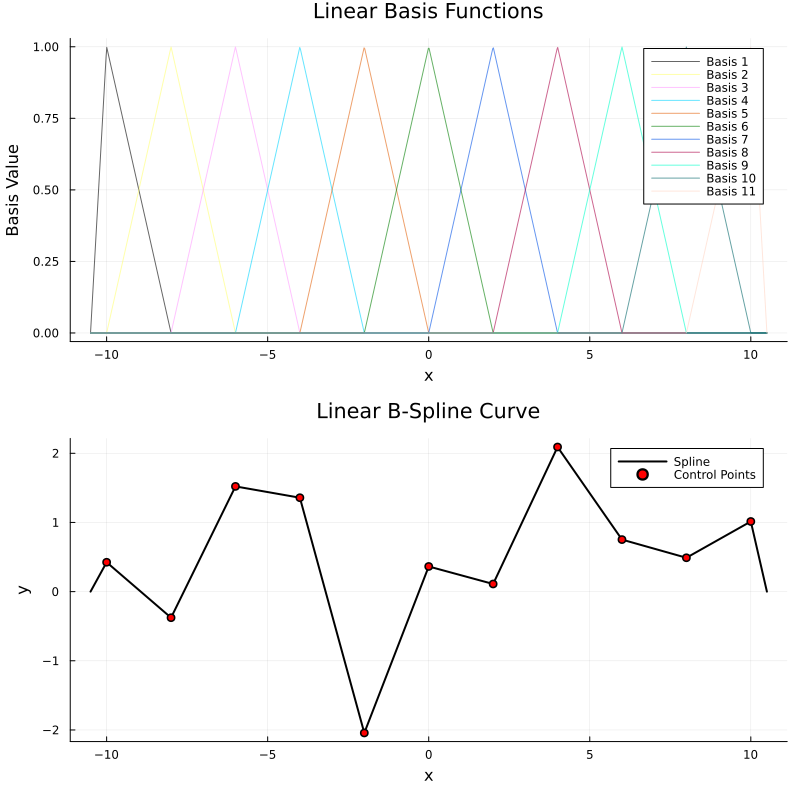

In [134]:
struct BSpline1
    grid_knots::Vector{Float64}  # size must be n + 2 * k + 1, where k = 1 for linear
    ctrl_points::Vector{Float64}  # size must be n + k
end

function BSpline1(lb::Float64, ub::Float64; n::Int = 20)
    k = 1  # degree 1 for linear spline
    # control points -- initialize randomly
    cpoints::Vector{Float64} = randn(Float64, n+k)
    grid_pts::Vector{Float64} = LinRange(lb, ub, n+1)
    # add 1 point before lower bound and 1 point after upper bound (k=1)
    pushfirst!(grid_pts, lb-0.5)
    push!(grid_pts, ub+0.5)
    BSpline1(grid_pts, cpoints)
end

function basis1(bs::BSpline1, x::Float64)
    # zeroth basis function (piecewise constant)
    b0::Vector{Float64} = (x .>= bs.grid_knots[1:end-1]) .& (x .< bs.grid_knots[2:end])
    
    # first basis functions (piecewise linear)
    b1_numerator_left = x .- bs.grid_knots[1:end-2]
    b1_denominator_left = bs.grid_knots[2:end-1] .- bs.grid_knots[1:end-2]
    b1_numerator_right = bs.grid_knots[3:end] .- x  
    b1_denominator_right = bs.grid_knots[3:end] .- bs.grid_knots[2:end-1]
    
    b1::Vector{Float64} = (b1_numerator_left ./ b1_denominator_left) .* b0[1:end-1] + 
                         (b1_numerator_right ./ b1_denominator_right) .* b0[2:end]
    
    return b1
end

function eval_linear_spline(bs::BSpline1, x)
    b1 = basis1(bs, x)
    b1 ⋅ bs.ctrl_points
end

function plot_linear_bspline_with_basis()
    # Create a B-spline of degree 1
    bs = BSpline1(-10.0, 10.0, n=10)  # fewer control points for clarity
    
    # Create range of x values for plotting
    x_range = LinRange(minimum(bs.grid_knots), maximum(bs.grid_knots), 1000)
    
    # Calculate basis functions for visualization
    b1_values = zeros(length(x_range), length(bs.grid_knots)-2)
    spline_values = zeros(length(x_range))
    
    # Calculate basis functions and spline values for each x
    for (i, x) in enumerate(x_range)
        b1 = basis1(bs, x)
        b1_values[i, :] = b1
        spline_values[i] = eval_linear_spline(bs, x)
    end
    
    # Create subplot for basis functions
    p1 = plot(title="Linear Basis Functions",
             xlabel="x",
             ylabel="Basis Value")
    
    # Plot each basis function with a different color
    colors = distinguishable_colors(size(b1_values, 2))
    for i in 1:size(b1_values, 2)
        plot!(p1, x_range, b1_values[:, i], 
              label="Basis $i",
              color=colors[i],
              linealpha=0.6)
    end
    
    # Create subplot for the resulting spline
    p2 = plot(title="Linear B-Spline Curve",
             xlabel="x",
             ylabel="y")
    
    # Plot the spline
    plot!(p2, x_range, spline_values, 
          label="Spline",
          color=:black,
          linewidth=2)
    
    # Add control points
    scatter!(p2, bs.grid_knots[2:end-1], bs.ctrl_points,
            label="Control Points",
            color=:red,
            markersize=4)
    
    # Combine plots
    plot(p1, p2, layout=(2,1), size=(800,800))
end

# Generate and display the plot
plot_linear_bspline_with_basis()

We'll follow the formula below for computing the 1st derivative:
![image.png](derivative.jpg)

Critical points found at x = [-10.999099909991, -10.275027502750277, -8.890889088908889, -6.702670267026703, -4.546454645464548, -3.3823382338233827, -1.838183818381836, 0.6540654065406528, 1.622162216221625, 2.3182318231823196, 3.5023502350235027, 4.446444644464446, 6.626662666266626, 10.003000300030003]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

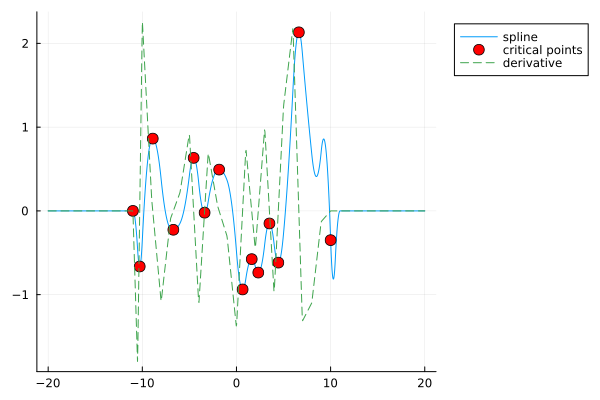

In [145]:
using LinearAlgebra
using Plots
using BenchmarkTools


# ===== First Degree Basis Functions =====

function basis1(bs::BSpline2, x::Float64, j::Int)
    """
    Compute first-degree (linear) basis function B_{j,1}(x)
    
    This function calculates the value of a first-degree B-spline basis function,
    which consists of two linear pieces forming a "hat" shape.
    
    Parameters:
    - bs: B-spline object containing knot vector
    - x: Point at which to evaluate the basis function
    - j: Index of the basis function
    
    Returns:
    - Value of the basis function at x
    """
    # Check if x is within the support of this basis function
    if x >= bs.grid_knots[j] && x < bs.grid_knots[j+2]
        # Calculate left piece of the hat function
        left_term = (x - bs.grid_knots[j]) / (bs.grid_knots[j+1] - bs.grid_knots[j])
        # Calculate right piece of the hat function
        right_term = (bs.grid_knots[j+2] - x) / (bs.grid_knots[j+2] - bs.grid_knots[j+1])
        
        # Return appropriate piece based on which interval x falls in
        return left_term * (x >= bs.grid_knots[j] && x < bs.grid_knots[j+1]) + 
               right_term * (x >= bs.grid_knots[j+1] && x < bs.grid_knots[j+2])
    end
    # Return 0 if x is outside the support
    return 0.0
end

function basis1_derivative(bs::BSpline2, x::Float64, j::Int)
    """
    Compute derivative of first-degree basis function B_{j,1}'(x)
    
    The derivative of a linear B-spline basis function is piecewise constant:
    - Positive constant in the left interval
    - Negative constant in the right interval
    - Zero elsewhere
    
    Parameters:
    - bs: B-spline object containing knot vector
    - x: Point at which to evaluate the derivative
    - j: Index of the basis function
    """
    if x >= bs.grid_knots[j] && x < bs.grid_knots[j+2]
        if x >= bs.grid_knots[j] && x < bs.grid_knots[j+1]
            # Positive slope in left interval
            return 1.0 / (bs.grid_knots[j+1] - bs.grid_knots[j])
        elseif x >= bs.grid_knots[j+1] && x < bs.grid_knots[j+2]
            # Negative slope in right interval
            return -1.0 / (bs.grid_knots[j+2] - bs.grid_knots[j+1])
        end
    end
    # Zero outside support
    return 0.0
end

# ===== Second Degree Basis Functions =====
function basis2(bs::BSpline2, x::Float64)
    n = size(bs.grid_knots)[1] - 1
    # these are the zeroth basis function
     b0::Vector{Float64} = (x .>= bs.grid_knots[1:end-1]) .& (x .< bs.grid_knots[2:end]) # piecewise constant
    # calculate the first basis functions
    b1_numerator_left = x .-  bs.grid_knots[1:end-2]
    b1_denominator_left = bs.grid_knots[2:end-1] .- bs.grid_knots[1:end-2]
    b1_numerator_right = bs.grid_knots[3:end] .- x  
    b1_denominator_right = bs.grid_knots[3:end]  .- bs.grid_knots[2:end-1]
     # piecewise linear functions
    b1::Vector{Float64} = (b1_numerator_left ./ b1_denominator_left) .* b0[1:end-1] + (b1_numerator_right ./ b1_denominator_right) .* b0[2:end]
    # calculate the second basis functions
    b2_numerator_left = x .- bs.grid_knots[1:end-3]
    b2_numerator_right = bs.grid_knots[4:end] .- x  
    b2_denominator_left = bs.grid_knots[3:end-1] .- bs.grid_knots[1:end-3] 
    b2_denominator_right = bs.grid_knots[4:end] .- bs.grid_knots[2:end-2]
     #piecewise quadratic functions.
    b2::Vector{Float64} = (b2_numerator_left ./ b2_denominator_left) .* b1[1:end-1] + (b2_numerator_right ./ b2_denominator_right) .* b1[2:end]
    return b2
 end

 
function basis2_derivative(bs::BSpline2, x::Float64, j::Int)
    """
    Compute derivative of second-degree basis function B_{j,2}'(x)
    
    Uses the formula for derivatives of B-splines in terms of lower degree basis functions:
    B_{j,2}'(x) = (1/(x_{j+2}-x_j)) * B_{j,1}(x) + 
                   ((x-x_j)/(x_{j+2}-x_j)) * B_{j,1}'(x) -
                   (1/(x_{j+3}-x_{j+1})) * B_{j+1,1}(x) +
                   ((x_{j+3}-x)/(x_{j+3}-x_{j+1})) * B_{j+1,1}'(x)
    """
    # Early return if x is outside the support of this basis function
    if !(bs.grid_knots[j] <= x < bs.grid_knots[j+3])
        return 0.0
    end
    
    # Calculate each term in the derivative formula
    # Term 1: First basis function scaled by reciprocal of knot difference
    term1 = (1.0 / (bs.grid_knots[j+2] - bs.grid_knots[j])) * basis1(bs, x, j)
    
    # Term 2: Derivative of first basis function scaled by normalized distance
    term2 = ((x - bs.grid_knots[j]) / (bs.grid_knots[j+2] - bs.grid_knots[j])) * basis1_derivative(bs, x, j)
    
    # Term 3: Second basis function scaled by reciprocal of knot difference
    term3 = (1.0 / (bs.grid_knots[j+3] - bs.grid_knots[j+1])) * basis1(bs, x, j+1)
    
    # Term 4: Derivative of second basis function scaled by normalized distance
    term4 = ((bs.grid_knots[j+3] - x) / (bs.grid_knots[j+3] - bs.grid_knots[j+1])) * basis1_derivative(bs, x, j+1)
    
    return term1 + term2 - term3 + term4
end

# ===== Complete B-spline Evaluation =====

function eval_derivative(bs::BSpline2, x::Float64)
    """
    Evaluate the derivative of the entire B-spline curve at point x
    
    This function computes the derivative by taking a weighted sum of the
    basis function derivatives, where the weights are the control points.
    """
    n = length(bs.ctrl_points)
    result = 0.0
    
    # Sum over all control points, multiplying each by its basis function derivative
    for j in 1:(n-2)  # Range adjusted for degree 2 B-spline
        result += bs.ctrl_points[j] * basis2_derivative(bs, x, j)
    end
    
    return result
end

function find_critical_points(bs::BSpline2, tolerance::Float64=1e-6)
    x = LinRange(-20.0, 20.0, 10000)
    y_deriv = [eval_derivative(bs, x_i) for x_i in x]
    sign_changes = Float64[]

    for i in 1:(length(y_deriv)-1)
        if sign(y_deriv[i+1]) != sign(y_deriv[i])
            push!(sign_changes, x[i+1])
        end
    end
    return sign_changes
end

function eval_spline(bs::BSpline2, x)
    b2 = basis2(bs, x)
    b2 ⋅ bs.ctrl_points
 end
 
# ===== Visualization =====

function plot_with_critical_points(bs::BSpline2)
    """
    Create a visualization of the B-spline curve with its critical points
    
    Plots:
    1. The original B-spline curve
    2. The derivative of the curve
    3. Critical points marked with red dots
    """
    # Generate x values for plotting
    x = LinRange(-20.0, 20.0, 1000)
    # Evaluate spline at each x
    y = [eval_spline(bs, x_elt) for x_elt in x]
    
    # Find and evaluate critical points
    crit_points = find_critical_points(bs)
    crit_values = [eval_spline(bs, x) for x in crit_points]
    
    # Create main plot with spline curve
    p = plot(x, y, label="spline", legend=:outertopright)
    
    # Add critical points as red dots
    scatter!(crit_points, crit_values, color=:red, 
            markersize=6, label="critical points")
    
    # Add derivative curve
    y_deriv = [eval_derivative(bs, x_elt) for x_elt in x]
    plot!(x, y_deriv, label="derivative", linestyle=:dash)
    print(y_deriv)
    
    return p
end

# Find and display critical points
critical_points = find_critical_points(bs)
println("Critical points found at x = ", critical_points)

# Create and display visualization
plot_with_critical_points(bs)


In [136]:
function eval_spline(bs::BSpline2, x)
   b2 = basis2(bs, x)
   b2 ⋅ bs.ctrl_points
end

eval_spline (generic function with 1 method)

Execution time:
  0.000004 seconds (3 allocations: 64 bytes)


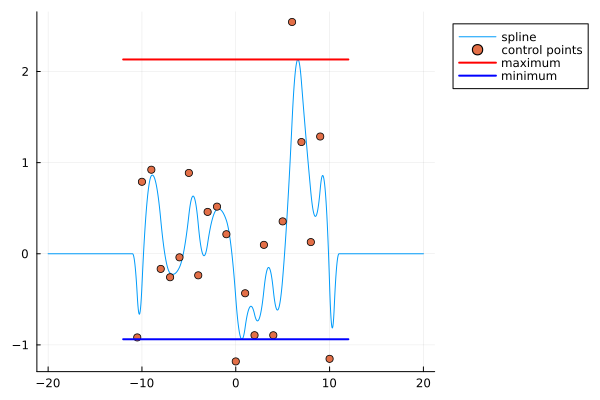

In [137]:
println("Execution time:")
critical_points = find_critical_points(bs)
y_vals = [eval_spline(bs, x_cp) for x_cp in critical_points]
@time max_y, min_y = maximum(y_vals), minimum(y_vals)
x_full = LinRange(-20, 20, 1000)
y_full = [eval_spline(bs, x_elt) for x_elt in x_full]
x_min, x_max = -12, 12
p = plot(x_full, y_full, label="spline", legend=:outertopright)
scatter!(bs.grid_knots[2:end-2], bs.ctrl_points, label="control points")
plot!([x_min, x_max], [max_y, max_y], color=:red, label="maximum", linewidth=2)
plot!([x_min, x_max], [min_y, min_y], color=:blue, label="minimum", linewidth=2)

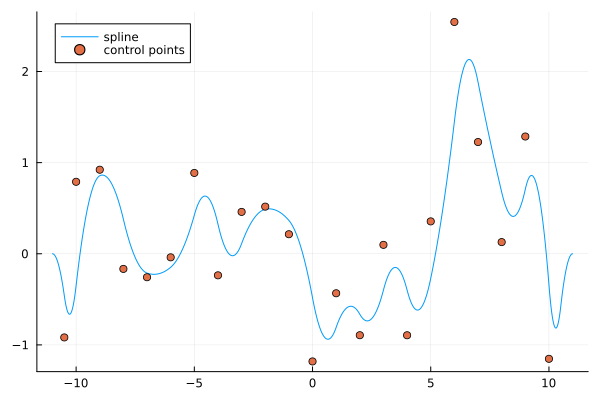

In [138]:
using Plots
x = LinRange(-11.0, 11.0, 1000)
y = [eval_spline(bs, x_elt) for x_elt in x]
plot(x, y, label="spline")
scatter!(bs.grid_knots[2:end-2], bs.ctrl_points, label="control points" )

Execution time:
  0.001413 seconds (69.00 k allocations: 7.698 MiB)


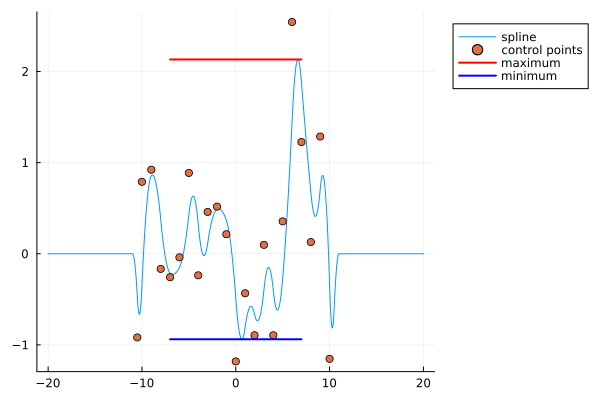

In [139]:
using Plots
using BenchmarkTools

function int_analysis_easy_way(bs::BSpline2)
    x = LinRange(-7.0, 7.0, 1000)
    y = [eval_spline(bs, x_elt) for x_elt in x]
    return maximum(y), minimum(y)
end

println("Execution time:")
@time max_y, min_y = int_analysis_easy_way(bs)
x_full = LinRange(-20.0, 20.0, 1000)
y_full = [eval_spline(bs, x_elt) for x_elt in x_full]
x_min, x_max = -7.0, 7.0
p = plot(x_full, y_full, label="spline", legend=:outertopright)
scatter!(bs.grid_knots[2:end-2], bs.ctrl_points, label="control points")
plot!([x_min, x_max], [max_y, max_y], color=:red, label="maximum", linewidth=2)
plot!([x_min, x_max], [min_y, min_y], color=:blue, label="minimum", linewidth=2)

Execution time:
  0.000029 seconds (15 allocations: 1.047 KiB)


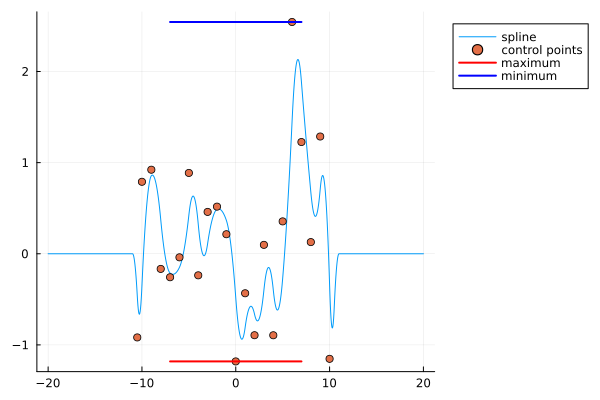

In [140]:
function int_analysis_convex_hull(bs::BSpline2, interval_start::Float64, interval_end::Float64)
    in_interval = []
    for i in 1:length(bs.ctrl_points)
        # using grid knots instead of control points because grid points correspond to x-axis while cp's are y-axis
        if interval_start <= bs.grid_knots[i+2] <= interval_end
            push!(in_interval, i)
        end
    end
    first_point = minimum(in_interval) - 1
    last_point = maximum(in_interval) + 1
    return minimum(bs.ctrl_points[first_point:last_point]), maximum(bs.ctrl_points[first_point:last_point])
end

x_full = LinRange(-20.0, 20.0, 1000)
y_full = [eval_spline(bs, x_elt) for x_elt in x_full]
x_min, x_max = -7.0, 7.0
println("Execution time:")
@time max_y, min_y = int_analysis_convex_hull(bs, -7.0, 7.0)
p = plot(x_full, y_full, label="spline", legend=:outertopright)
scatter!(bs.grid_knots[2:end-2], bs.ctrl_points, label="control points")
plot!([x_min, x_max], [max_y, max_y], color=:red, label="maximum", linewidth=2)
plot!([x_min, x_max], [min_y, min_y], color=:blue, label="minimum", linewidth=2)

In [141]:
function find_first_derivative(bs::BSpline2)
    
    

Base.Meta.ParseError: ParseError:
# Error @ /Users/noahschwartz/Desktop/Verifying NNs/KAN/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X23sZmlsZQ==.jl:3:5
    
    
#   └ ── premature end of input

In [142]:
struct BSplineVector
    grid_knots::Vector{Float64} # size must be n + 2 * k + 1
    ctrl_points::Matrix{Float64} # size must be (n + k) * d wherein d is the number of dimensions of the vector 
end


May be useful in the future? Formula below for computing the b-spline of degree 3 given a b-spline of degree 2:
![image.png](degree3.jpg)